# 3.1 Этапы анализа данных
Процесс исследования, обработки, модификации и моделирования данных 

с целью извлечения информации и принятия решений:
- Проектирование данных (`что?`, `где?`, `когда?`, `зачем?`) 
- Сбор данных
- Предобработка данных 
    - очистка
    - форматирование
    - масштабирование
    - кодирование
    - создание модификаций
- Разработка схемы данных
- Аналитические исследования
- Представление результатов (как правило, с визуализацией и публикацией)
- Принятие неудачного результата 
    - почему исследование частично или полностью не удалось
- Выводы

In [1]:
# подключение пакетов
import os, sqlite3, pandas as pd, numpy as np, pylab as pl
from IPython.display import display, HTML
from IPython.core.magic import register_line_magic

## I. Проектирование
Определение цели исследования:
- формулировка задач
    - увеличить (уменьшить) пассажиропок
- постановка вопросов
    - какие тенденции есть на рынке труда
- выявление проблем
    - почему фирма теряет клиентов
- оценка возможности прогнозирования
    - можно ли предсказать изменения на рынке ценных бумаг

Определение параметров информации:
- какие данные собираем (типы данных, форматы файлов и пр.)
- временной отрезок (краткосрочные или долгосрочные наблюдения)
- где получить максимально достоверные и полные сведения
- на какие вопросы могут "ответить" собранные данные

In [2]:
# пример "легкого проектирования" - 
# загрузка в SQL имеющегося файла csv 

# функция для создания примера базы данных
def connect_to_db(dbf):
    sqlconn=None
    try: sqlconn=sqlite3.connect(dbf); return sqlconn
    except sqlite3.Error as err:
        print(err)
        if sqlconn is not None: sqlconn.close()
connection=connect_to_db('example.db')
# инструмент для запуска запросов
if connection is not None: 
    cursor=connection.cursor()

In [3]:
# описание гипертекстовой разметки представления
thp=[('font-size','15px'),('text-align','center'),
     ('font-weight','bold'),('padding','5px 5px'),
     ('color','white'),('background-color','slategray')]
tdp=[('font-size','14px'),('padding','5px 5px'),
     ('text-align','center'),('color','darkblue'),
     ('background-color','silver')]
style_dict=[dict(selector='th',props=thp),
            dict(selector='td',props=tdp)]
# объявление функции с возможностью вызова магической командой
@register_line_magic
def get_query(q):
    global cursor
    print('SQL Queries')
    # запуск запроса
    tr=[]; cursor.execute(q)
    # сохранение результатов запроса
    result=cursor.fetchall()
    for r in result: tr+=[r]
    # оформление результатов запроса в виде рамки данных
    display(pd.DataFrame.from_records(tr)\
            .style.set_table_styles(style_dict))

In [4]:
# pandas загружает в рамку данных csv
url='https://raw.githubusercontent.com/noahgift/'+\
    'mma/master/data/ufc_fights_all.csv'
mma=pd.read_csv(url).dropna()
# pandas загружает рамку данных в базу sql
mma.to_sql('mma',con=connection,if_exists='replace')
mma.tail(int(2)).T.style.set_table_styles(style_dict)

,3567,3568
pageurl,/events/UFC-Fight-Night-83-Cerrone-vs-Oliveira-47935,/events/UFC-Fight-Night-83-Cerrone-vs-Oliveira-47935
eid,47935,47935
mid,2,1
event_name,UFC Fight Night 83 - Cerrone vs. Oliveira,UFC Fight Night 83 - Cerrone vs. Oliveira
event_org,Ultimate Fighting Championship,Ultimate Fighting Championship
event_date,2/21/16,2/21/16
event_place,"Consol Energy Center, Pittsburgh, Pennsylvania, United States","Consol Energy Center, Pittsburgh, Pennsylvania, United States"
f1pageurl,/fighter/Lauren-Murphy-66725,/fighter/Shamil-Abdurakhimov-26808
f2pageurl,/fighter/Kelly-Faszholz-117453,/fighter/Anthony-Hamilton-58947
f1name,Lauren Murphy,Shamil Abdurakhimov


In [5]:
# часть схемы данных - информация о полях одной таблицы
%get_query \
PRAGMA table_info('mma')

SQL Queries


,0,1,2,3,4,5
0,0,index,INTEGER,0,None,0
1,1,pageurl,TEXT,0,None,0
2,2,eid,INTEGER,0,None,0
3,3,mid,INTEGER,0,None,0
4,4,event_name,TEXT,0,None,0
5,5,event_org,TEXT,0,None,0
6,6,event_date,TEXT,0,None,0
7,7,event_place,TEXT,0,None,0
8,8,f1pageurl,TEXT,0,None,0
9,9,f2pageurl,TEXT,0,None,0


## II. Сбор данных
Уровни сбора данных:
- первичный 
    - прямой контакт с источником информации
        - опрос покупателей
        - таблицы транзакций
        - автоматическая фиксация показаний приборов
        - фотографии и видео
        - ...
- вторичный 
    - обработанные организациями первичные данные
        - история онлайн-покупок 
        - данные о доставке
        - действия на веб-сайтах
    - более структурированы
    - достаточно надежны, но часть информации утрачена
    - Примеры: 
        - [Лента Онлайн](https://online.lenta.com)
        - [CustomWeather](https://customweather.com/products/real-time/)
- агрегированный
    - собраны из многочисленных источников сторонней организацией
        - большие данные для создания отраслевых отчетов 
        - проведение маркетинговых исследований
        - хранилища открытых данных
        - правительственные порталы
    - большое количество записей, возможно, что и разной структуры
    - Пример: [NYC Open Data](https://opendata.cityofnewyork.us)

In [6]:
# пример вторичных сведений (обучающий)
path = 'https://raw.githubusercontent.com/The-Calculated-Life/'+\
       'python_analysis_for_excel/main/data/'
failed_bank_file = 'failed_banks.xlsx'
pd.read_excel(path + failed_bank_file).head()

,CERT,Bank Name,City,ST,Acquiring Institution,Closing Date
0,14361,The First State Bank,Barboursville,WV,"MVB Bank, Inc.",2020-04-03
1,18265,Ericson State Bank,Ericson,NE,Farmers and Merchants Bank,2020-02-14
2,21111,City National Bank of New Jersey,Newark,NJ,Industrial Bank,2019-11-01
3,58317,Resolute Bank,Maumee,OH,Buckeye State Bank,2019-10-25
4,58112,Louisa Community Bank,Louisa,KY,Kentucky Farmers Bank Corporation,2019-10-25


## III. Предобработка
Цель - легче отображать данные и управлять ими.
### Очистка данных
- удаление / исправление / определение
    - ошибок
    - дубликатов
    - выбросов (аномалий)
- удаление / пометка ненужных точек данных
    - наблюдений, которые не имеют отношения к предполагаемому анализу
- cтруктурирование (общая «хозяйственная работа») 
    - исправление опечаток или проблем с индексированием данных
- заполнение пробелов (отсутствующих значений) корректным методом

### Форматирование данных 
- перевод имеющихся значений в другой тип данных 
    - вещественные (1.0) ==> в целочисленные (1)
- конвертирование файлов в другой формат
- ...

### Масштабирование данных
- преобразование входного набора данных в выходной набор в заданном диапазоне

### Кодирование данных
- проекция значений данных номинального и порядкового типов

  в бинарное или целочисленное представление
    - (мужской, женский) ==> (0, 1)
    - (холодно, тепло, жарко, горячо) ==> (0, 1, 2, 3) или (00, 01, 10, 11)
- численное представление неопределенных ответов 
    - да, нет, не знаю?!!!

### Сохранение результатов предобработки
Предобработка - трудоемкий и долгий этап.

Его результаты, как правило, сохраняются в виде файлов или модицикаций баз данных.

---

Иногда предобработка - это еще и проведение первичного исследовательского анализа. 

Она помогает определить тенденции и характеристики и 

даже может уточнить гипотезы (предположения о закономерностях).

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


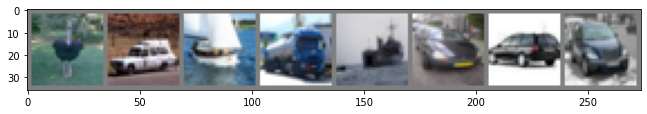

     bird       car      ship     truck      ship       car       car       car
000000002 000000001 000000008 000000009 000000008 000000001 000000001 000000001


In [7]:
# пример обработки изображений
import numpy as np, pylab as pl, torch,torchvision
import torchvision.transforms as transforms
# нормализация и создание массива с "памятью" о математических операциях
tr0 = (.5,.5,.5)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(tr0,tr0)])
# загрузка данных с трансформацией
trainset = torchvision.datasets.CIFAR10(
    root='./data',train=True,
    download=True,transform=transform)
# смешивание данных и разделение на порции
trainloader=torch.utils.data.DataLoader(
    trainset,batch_size=8,
    shuffle=True,num_workers=2)
# информация о категориях изображений 
# (в переменной labels - в численном выражении)
classes=('plane','car','bird','cat','deer',
         'dog','frog','horse','ship','truck')
def imshow(img):
    npimg = img.numpy()/2.+.5
    pl.figure(figsize=(11,2))
    tr1 = (1,2,0)
    pl.imshow(np.transpose(npimg,tr1))
    pl.show()
# итерация по данным
dataiter = iter(trainloader)
# разделение на изображения и метки
images,labels = next(dataiter)
# создание набора фото для иллюстрации
imshow(torchvision.utils.make_grid(images))
# распечатка категорий изображений и их кодов (меток)
print(' '.join('%09s'%classes[labels[j]] for j in range(8)))
print(' '.join('%09d'%labels[j] for j in range(8)))

## IV. Разработка схемы данных
Структура данных:
- количество, наименование и назначение разделов
- состав разделов (из каких полей или объектов состоят)
- взаимодействия разделов внутри одной базы и с внешними источниками
- доступ к данным

Автоматизированные системы управления базами данных (СУБД) могут также хранить
- функции и процедуры
- представления данных
- схемы связей по полям
- ...

Даже для небольших коллекций информации рекомендуется создавать 

визуальный элемент, который описывает архитектуру базы данных.




In [8]:
# предварительно необходимо запустить код в разделе I
# обучающий пример разработки схемы данных
cursor.execute('''
CREATE TABLE IF NOT EXISTS projects (
id integer PRIMARY KEY,
name text NOT NULL,
begin_date text,
end_date text);
''')
cursor.execute('''
CREATE TABLE IF NOT EXISTS tasks (
id integer PRIMARY KEY,
name text NOT NULL,
priority integer,
status_id integer NOT NULL,
project_id integer NOT NULL,
begin_date text NOT NULL,
end_date text NOT NULL,
FOREIGN KEY (project_id) REFERENCES projects (id)
);
''')

In [9]:
# обучающий пример загрузки данных согласно разработанной схеме
def create_project(cursor,project):
    q='''INSERT INTO projects(name,begin_date,end_date)
         VALUES(?,?,?)'''
    cursor.execute(q,project)
    return cursor.lastrowid
def create_task(cursor,task):
    q='''INSERT INTO tasks(
         name,priority,status_id,project_id,begin_date,end_date
         ) VALUES(?,?,?,?,?,?)'''
    cursor.execute(q,task)
    return cursor.lastrowid
project1=('SQL CookBook with SageMathCell','2020-02-04','2020-02-18')
project2=('SQL Tests','2020-01-31','2020-02-14')
project_id1=create_project(cursor,project1)
project_id2=create_project(cursor,project2)
t=[('Page 1',int(1),int(1),project_id1,'2020-02-04','2020-02-12'),
   ('Page 2',int(1),int(1),project_id1,'2020-02-10','2020-02-18'),
   ('Test 1',int(1),int(1),project_id2,'2020-01-31','2020-02-01'),
   ('Test 2',int(1),int(1),project_id2,'2020-02-02','2020-02-03'),
   ('Test 3',int(1),int(1),project_id2,'2020-02-04','2020-02-05'),
   ('Test 4',int(1),int(1),project_id2,'2020-02-06','2020-02-07'),
   ('Test 5',int(1),int(1),project_id2,'2020-02-08','2020-02-09'),
   ('Test 6',int(1),int(1),project_id2,'2020-02-09','2020-02-10'),
   ('Test 7',int(1),int(1),project_id2,'2020-02-10','2020-02-11'),
   ('Dublicate',int(1),int(1),project_id2,'2020-02-11','2020-02-14')]
for task in t: create_task(cursor,task)

In [10]:
%get_query \
PRAGMA table_info('projects')

SQL Queries


,0,1,2,3,4,5
0,0,id,integer,0,None,1
1,1,name,text,1,None,0
2,2,begin_date,text,0,None,0
3,3,end_date,text,0,None,0


## V. Аналитические исследования
- Описательный анализ / `Descriptive analysis` /

    - обзор произошедших событий
    - первый этап исследований в большинстве случаев 
    - состав:
        - обработка эмпирических данных
        - их систематизация и обобщение
        - наглядное представление в форме графиков и таблиц
        - количественные статистические показатели
    - основа для более глубокой аналитики  
- Диагностическая аналитика / `Diagnostic analysis` /

    - определении причин событий ("симптомы болезни")
    - доказательства закономерностей в данных
- Прогнозирующая аналитика / `Predictive analysis` /

    - определение тенденций развития на основе имеющихся данных
    - все чаще используются алгоритмы машинного обучения
    - вероятно, самая опасная сфера аналитики
- Предписывающий анализ / `Prescriptive  analysis` /

    - рекомендации на будущее ("что делать") 
    - как правило, самый последний и самый сложный шаг в аналитике 
    - должен максимально гибко адатироваться к новым условиям
    - мера ответственности исследований

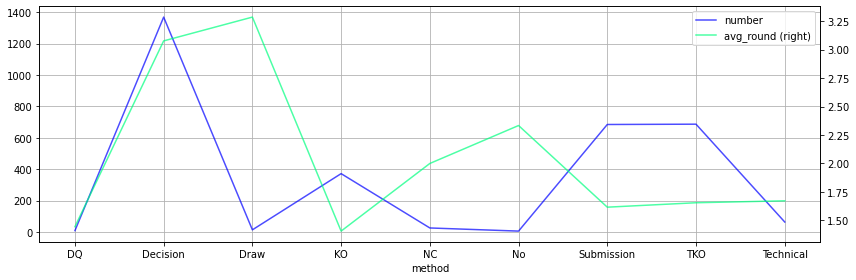

,number,avg_round
method,,
NC,26,2.000000
No,6,2.333333
Submission,685,1.616058
TKO,687,1.655022
Technical,64,1.671875


In [11]:
# диагностический анализ
# группировка по методам победы на бойцовских рингах
q=pd.read_sql_query('''
SELECT method,
       COUNT(*) AS number,
       AVG(round) AS avg_round
FROM mma
GROUP BY method;
''',con=connection).set_index('method')
q.plot(secondary_y='avg_round',figsize=(12,4),
       cmap=pl.cm.winter,alpha=.7,grid=True)
pl.tight_layout(); pl.show()
q.tail().style.set_table_styles(style_dict)

## VI. Представление результатов

Цель — поделиться знаниями о выявленных закономерностях:
- открытые публикации
- конкурсные работы
- соревнования
- заинтересованные подразделения внутри организации
- ...

Этап состоит из 
- интерпретации результатов и 
- их представления удобным для аудитории способом

Формы представления: 
- отчеты
- информационные панели
- интерактивные визуализации
- веб-страницы
- новостные статьи
- ...

В представлении результатов важна степень осознания ответственности:
- на 100% ясная и недвусмысленная трактовка
- доказательность и научная обоснованность (не только собранные сведения!) 
- максимально лаконичное содержание 
- открытость для инноваций 

Аналитика напрямую влияет на жизненный цикл бизнеса: 
- решения о реструктуризации
- запуск продукта с высокой степенью риска
- закрытие подразделений
- ...

Графические инструменты аналитика:
- требующие минимальных навыков программирования или вообще не требующие их
    - Google Charts, Tableau, Datawrapper, Infogram
- Python
    - Plotly, Seaborn, Matplotlib, Altair, Bokeh, Folium
- средства других языков c их библиотеками
    - JS D3, JS Highcharts, R ggplot2, R ggvis, R Lattice

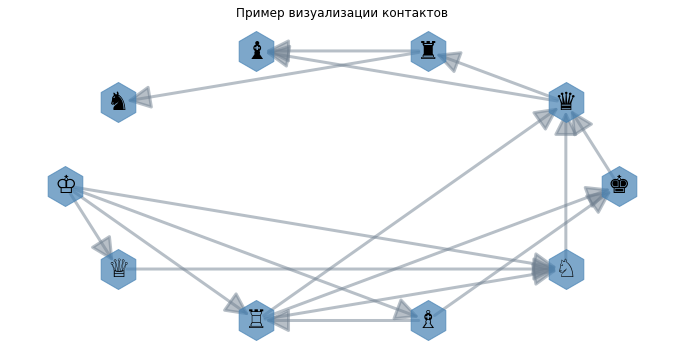

In [12]:
# схему контактов клиентов, организаций и пр.
# часто выполняют в виде графа: узлы и соединения
import networkx as nx, pylab as pl
# создание графа и сведений о взаимодействиях
G3=nx.MultiDiGraph()
edges=[('♔','♕'),('♔','♖'),('♔','♗'),
       ('♔','♘'),('♕','♘'),('♖','♘'),
       ('♖','♚'),('♖','♛'),('♗','♖'),
       ('♗','♚'),('♘','♛'),('♚','♛'),
       ('♛','♜'),('♛','♝'),('♜','♝'),('♜','♞')]
# загрузка данных в граф
G3.add_edges_from(edges); pos=nx.shell_layout(G3)
# графическое представление
pl.figure(figsize=(12,6)); pl.axis('off')
pl.title('Пример визуализации контактов')
nx.draw_networkx_edges(
    G3,pos,width=3,alpha=.5,edge_color='slategray',
    arrowsize=50,arrowstyle='-|>')
nx.draw_networkx_nodes(
    G3,pos,node_size=1600,alpha=.7,
    node_shape='h',node_color='steelblue')
nx.draw_networkx_labels(
    G3,pos,font_size=25,font_weight='bold');

## VII. Принятие неудач

Ошибки аналитики были, есть и всегда будут. 

Наиболее частая причина - от недостоверности или неполноты информации.

Способность учиться на своих и чужих ошибках превращает 

хорошего аналитика данных в прекрасного специалиста.

Одно из главных свойств профессионала - 

не принимать на свой счет невыполнимость поставленных задач.

In [13]:
# удаляем обучающую базу данных
# ошибок мы вряд ли много наделали :)
if connection is not None: connection.close()
if os.path.exists('example.db'): os.remove('example.db')
else: print('The file does not exist')

## VII. Выводы
Краткое заключение с описанием основных этапов исследования

и дальнейших перспектив как самой базы данных, так и аналитики.

Формы представления:
- в виде последнего пункта документа
- отдельный текстовый файл с результатами
- обобщающая визуализация 